2019.08.02  
SR:  Doing a visual check of some COSMOS DEIMOS spectra to verify that the SNANA simulated spectra are approximately correct

In [113]:
%matplotlib inline

In [3]:
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
import numpy as np
import os
from matplotlib import pyplot as plt
import sncosmo

In [4]:
medsmooth = lambda f, N : np.array([np.median(
    f[max(0,i-N):min(len(f),max(0,i-N)+2*N)]) for i in range(len(f))])

In [5]:
flcdm = FlatLambdaCDM(H0=73, Om0=0.27)

## read in the little table of COSMOS ground spectra
This is a table of COSMOS galaxies with DEIMOS spectra that lie within the part of the COSMOS field covered by CANDELS and 3DHST.  I built this by manually entering the RA,Dec limits of the CANDELS cosmos footprint on the COSMOS DEIMOS data site at IRSA (https://irsa.ipac.caltech.edu/data/COSMOS/spectra/deimos/deimos.html)

In [6]:
spec_cat = Table.read('cosmos_spec_match_cat.tbl', format='ascii.ipac')
ra1 = spec_cat['ra'] #* u.degree
dec1 = spec_cat['dec'] #* u.degree
z1 = spec_cat['zspec']
distance1 = flcdm.luminosity_distance(z1)
cat1 = SkyCoord(ra=ra1, dec=dec1, distance=distance1)

## read in the SNANA hostlib file
This is the hostlib file constructed with the jupyter notebook 3DHST_to_hostlib.ipynb

In [7]:
hostlib = Table.read('cosmos_hostlib.txt', format='ascii')
ra2 = hostlib['RA_GAL'] * u.degree
dec2 = hostlib['DEC_GAL'] * u.degree
z2 = hostlib['ZTRUE']
distance2 = flcdm.luminosity_distance(z2)
cat2 = SkyCoord(ra=ra2, dec=dec2, distance=distance2)

## find matches between the two catalogs
and require that they lie within 1 arcsec



In [8]:
idx, d2d, d3d = cat1.match_to_catalog_3d(cat2)

# require matches within 1 arcsec
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep
cat1_matches = cat1[sep_constraint]
cat2_matches = cat2[idx[sep_constraint]]


# Now, cat1_matches and cat2_matches are the matched sources in cat1 and cat2, respectively, which are separated by less than 1 arcsecond.

## write out the little catalog of a few dozen matches in several formats

In [9]:
# add the SNANA hostlib galaxy ID as a new column, 
# remove some un-needed columns, and write it to a file

spec_cat_matches = spec_cat[sep_constraint]
hostlib_galid_matches = hostlib['GALID'][idx[sep_constraint]]
spec_cat_matches.add_column(hostlib_galid_matches, index=0)
spec_cat_matches.remove_columns(['sel','Qf', 'Q', 'Remarks'])

irsa = "https://irsa.ipac.caltech.edu"
for colname in ['fits1d', 'ascii1d', 'jpg1d','fits2d']:
    newdat = np.array([irsa + s.split('"')[1] for s in spec_cat_matches[colname]])
    spec_cat_matches[colname] = Column(data=newdat, name=colname)

spec_cat_matches.write("cosmos_example_spectra.csv", 
                       format='ascii.csv', overwrite=True)

spec_cat_matches.write("cosmos_example_spectra.txt", 
                       format='ascii.fixed_width', overwrite=True)

spec_cat_matches.write("cosmos_example_spectra.fits", 
                       format='fits', overwrite=True)

## Make a plot of one of the observed spectra and check the magnitude

In [87]:
def get_specdata(galaxy_index):
    # TODO: read the table directly from the URL, instead of a downloaded copy
    filename = os.path.basename(spec_cat_matches['ascii1d'][galaxy_index])
    spec1 = Table.read(filename, format='ascii.commented_header', 
                       header_start=-1, data_start=0)
    #wavesteps = np.append(np.diff(spec1['wavelength']),[0])
    flam = np.array(spec1['flux'])
    wave = np.array(spec1['wavelength'])
    # Plotting the spectrum as the COSMOS DEIMOS team did:
    flam_med = medsmooth(flam, 20)
    return(wave, flam, flam_med)

In [96]:
def plot_flambda(galaxy_index, ax=None):
    wave, flam, flam_med = get_specdata(galaxy_index)
    if ax is None:
        ax = plt.gca()   

    ax.plot(wave, flam, lw=0.05, color='grey')
    ax.plot(wave, flam_med, lw=0.5, color='darkblue')

    ax.set_xlim(4800,10400)
    ax.set_ylim(-101,180)
    ax.set_xlabel('wavelength ($\AA$)')
    ax.set_ylabel('f$_\lambda$ (in 1e-17 erg/s/cm2/A)')

In [97]:
def scale_to_match_imag(galaxy_index, ax=None):
    """KLUDGE!!  Using sncosmo to make this galaxy SED into a Source so we can integrate into mags using the sncosmo bandmag, and rescale to match a pre-defined mag"""    
    
    phase = np.array([-1, 0, 1, 2]) # need at least 4 phase positions for a source
    wave, flam, flam_med = get_specdata(galaxy_index)
    flux = np.array([flam_med, flam_med, flam_med, flam_med])*1e-17 # Use the median-smoothed version
    galsource = sncosmo.TimeSeriesSource(phase, wavelength, flux)

    
    imag = spec_cat_matches['imag'][galaxy_index]
    galsource.set_peakmag(imag, 'sdssi', 'ab')
    w = np.arange(5000,10000,10.)

    if ax is None:
        ax = plt.gca()

    ax.plot(w, galsource.flux(0, w))
    ax.set_xlim(4800,10400)
    #ax.set_ylim(-10,80)
    ax.set_xlabel('wavelength ($\AA$)')
    ax.set_ylabel('f$_\lambda$ (erg/s/cm2/A)')

    # For this galaxy, the scaling factor that makes the spectrum match the i band mag
    scale_factor = np.median(flam_med*1e-17 / galsource.flux(0, wavelength))
    ax.text(0.05,0.9, "scale to match i mag = {:.1f}".format(scale_factor), ha='left', va='top', transform=ax.transAxes)
    


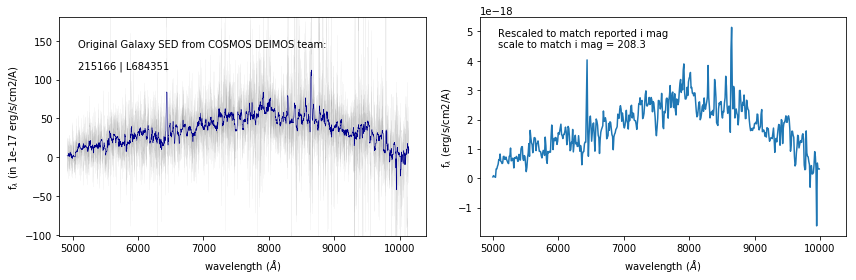

In [102]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_flambda(1, ax1)
ax1.text(0.05, 0.9, "Original Galaxy SED from COSMOS DEIMOS team:", 
         ha='left', va='top', transform=ax1.transAxes)

ax1.text(0.05, 0.8, "215166 | L684351", 
         ha='left', va='top', transform=ax1.transAxes)

scale_to_match_imag(1, ax2)
ax2.text(0.05,0.95, "Rescaled to match reported i mag", 
         ha='left', va='top', transform=ax2.transAxes)

plt.tight_layout()

In [118]:
def show_rescaled_spec(galnum=1):
    fig = plt.figure(figsize=[12,4])
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    plot_flambda(galnum, ax1)
    ax1.text(0.05, 0.9, "Original Galaxy SED from COSMOS DEIMOS team:", 
             ha='left', va='top', transform=ax1.transAxes)

    ax1.text(0.05, 0.8, "{:d} | {:s}".format( spec_cat_matches['GALID'][galnum], 
                                             spec_cat_matches['ID'][galnum]),
             ha='left', va='top', transform=ax1.transAxes)


    scale_to_match_imag(galnum, ax2)
    ax2.text(0.05,0.95, "Rescaled to match reported i mag", 
             ha='left', va='top', transform=ax2.transAxes)

    plt.tight_layout()

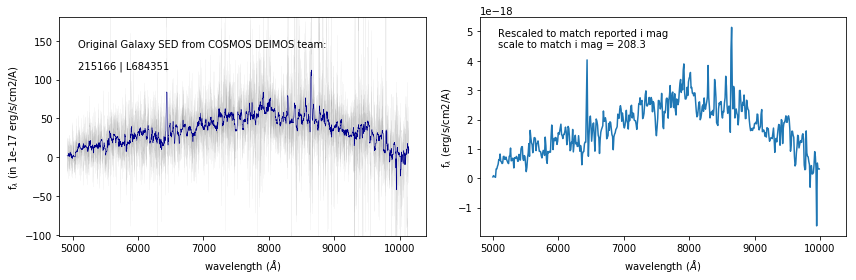

In [119]:
show_rescaled_spec(1)

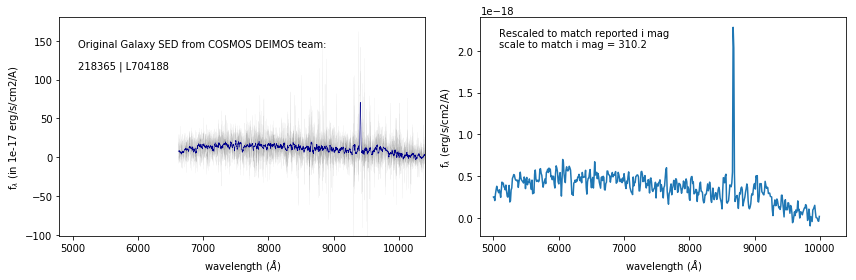

In [120]:
show_rescaled_spec(2)

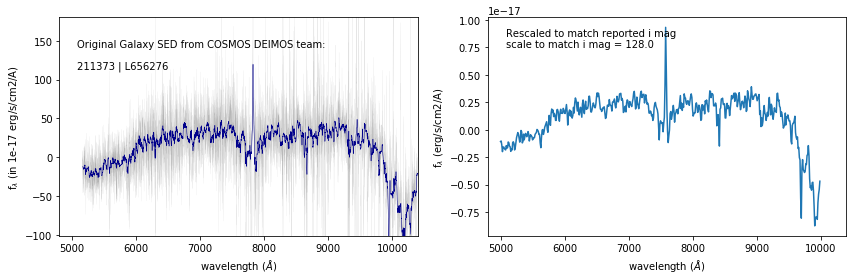

In [122]:
show_rescaled_spec(3)